# Preprocessing

In this tutorial we will show how to construct a preprocessing pipeline to "prepare" your recording prior to spike sorting.
While some of the steps that we'll see are Neuropixels specific, most of the concepts can be applied to any probe device.

In [1]:
from pathlib import Path
import numpy as np

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw

import matplotlib.pyplot as plt

In [2]:
%matplotlib widget

## "Destriping" the raw traces

Neuropixels probes (and similar) have long shanks that can experience noise that appear as "stripes".
This section shows how to clean the signals and remove bad channels prior to spike sorting.

To demonstrate this, we are going to use some test datasets shared by Olivier Winter from IBL.

For more information, please refer to the IBL paper:

[Spike sorting pipeline for the International Brain Laboratory, ](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522/3)

In [5]:
base_folder = Path("../")

In [6]:
preprocessing_folder = base_folder / "dataset_preprocessing"
destriping_folder = preprocessing_folder / "destriping"
session = "8413c5c6-b42b-4ec6-b751-881a54413628"

In [5]:
ibl_data_cbin_file = [p for p in (destriping_folder / session).iterdir() if p.name.endswith(".ap.cbin")][0]

In [6]:
recording = se.read_cbin_ibl(cbin_file=ibl_data_cbin_file)
recording

CompressedBinaryIblExtractor: 384 channels - 30.0kHz - 1 segments - 30,000 samples - 1.00s 
                              int16 dtype - 21.97 MiB

Let's first take a look at the "raw" traces:

In [7]:
w = sw.plot_traces(recording, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

We notice there are both some horizontal and vertical "stripes", plus some "patterns".

Although Neuropixels data have a hardware highpass filter (cutoff at 150Hz), there can be come leftover content from the LFP frequency band.

So let's first highpass the data and see how it looks:

In [8]:
recording_hp = spre.highpass_filter(recording)

# we can visualize multiple "layers" at the same time!
recording_layers = dict(
    raw=recording,
    highpass=recording_hp
)
w = sw.plot_traces(recording_layers, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Remove artifacts due to optogenetics stimulation

In [7]:
dataset_artifacts =  preprocessing_folder / "artifacts"
recording_artifact_path = dataset_artifacts / "preprocessing_artifact_recording.zarr"
events_path = dataset_artifacts / "opto_stimulation_events.npy"

In [8]:
recording_artifacts = si.load_extractor(recording_artifact_path)
recording_artifacts

ZarrRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 90,000 samples - 3.00s - int16 dtype 
                        65.92 MiB

Note: this dataset is from Neuropixels 2.0, which, differently from 1.0, records a wideband signal without hardware filters.

Let's load the event information, which include the time, duration, and label for each stimulation event:

In [9]:
recording_hp_artifacts = spre.highpass_filter(recording_artifacts)
recording_ps_artifacts = spre.phase_shift(recording_hp_artifacts)

**NOTE:** since both filtering and phase-shift are linear operations, the order doesn't matter!

In [10]:
recording_notch = spre.notch_filter(recording_ps_artifacts, freq=10000, q=30)

In [11]:
recording_layers = dict(
    raw=recording_artifacts,
    highpass=recording_hp_artifacts,
    phase_shift=recording_ps_artifacts,
    notch=recording_notch
)

w = sw.plot_traces(recording_layers, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [15]:
rec = recording_notch

In [18]:
si.set_global_job_kwargs(n_jobs=4)

In [18]:
rec = recording_notch

In [19]:
noise_levels = si.get_noise_levels(rec, force_recompute=True)

In [36]:
amplitude_threshold = 400 # uV
derivative_threshold = 50 #uv/sample
baseline_threshold = 100 #uv
min_channels_affected_ratio = 0.25
ms_before = ms_after = 4

In [37]:
detect_threshold_mad = amplitude_threshold / np.median(rec.get_channel_gains()) / np.median(noise_levels)
radius_um = np.max(si.get_channel_distances(rec)) + 1

In [79]:
rec

NotchFilterRecording: 384 channels - 30.0kHz - 1 segments - 90,000 samples - 3.00s - int16 dtype 
                      65.92 MiB

In [24]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

def detect_transient_artifact(
    recording, 
    amplitude_threshold=400, # uV
    derivative_threshold=50, #uv/sample
    baseline_threshold=100, #uv
    min_channels_affected_ratio=0.25,
    minimum_width_ms=0.2,
    ms_before=4,
    ms_after=4,
    num_samples_moving_average=10,
    num_samples_around_peak=20,
    noise_levels=None
):
    from spikeinterface.sortingcomponents.peak_detection import detect_peaks
    if noise_levels is None:
        noise_levels = si.get_noise_levels(recording, force_recompute=True)

    exclude_sweep_ms = np.max([ms_before, ms_after])
    detect_threshold_mad = amplitude_threshold / np.median(recording.get_channel_gains()) / np.median(noise_levels)
    radius_um = np.max(si.get_channel_distances(recording)) + 1

    peaks = detect_peaks(
        recording,
        method="locally_exclusive",
        radius_um=radius_um,
        detect_threshold=detect_threshold_mad,
        exclude_sweep_ms=exclude_sweep_ms,
        peak_sign="both",
    )

    print(f"Found {len(peaks)}")
    # For each peak test whether:
    # - enough channels are affected, if not: remove (done)
    # - find onset and find offset (back to noise level) (done)
    # - rise time is fast enough, if not: remove (done)
    n_pre = int(ms_before / 1000 * recording.sampling_frequency)
    n_post = int(ms_after / 1000 * recording.sampling_frequency)
    silence_intervals = []

    for i_p, p in enumerate(peaks):
        peak_index = p["sample_index"]
        start_frame = peak_index - n_pre
        if start_frame < 0:
            start_frame = 0
        end_frame = peak_index + n_post
        if end_frame >= recording.get_num_samples():
            end_frame = recording.get_num_samples() - 1
        # get trace snippet around peak
        traces = recording.get_traces(start_frame=start_frame, end_frame=end_frame, return_scaled=True)
        traces_abs = np.abs(traces)

        # 1. check if enough channels are affected
        peak_by_channel = np.max(
            traces_abs[peak_index - start_frame - num_samples_around_peak:
            peak_index - start_frame + num_samples_around_peak],
            axis=0
        )
        channels_affected_mask = peak_by_channel > detect_threshold_mad * noise_levels 
        channels_affected_ratio = np.sum(channels_affected_mask)  / recording.get_num_channels()
        if channels_affected_ratio < min_channels_affected_ratio:
            print(f"Noise event excluded for channel ratio: {channels_affected_ratio}")

        # 2. find onset and offset on the affected channels
        traces_affected_abs = traces_abs[:, channels_affected_mask]
        median_abs_artifact = np.median(traces_affected_abs, 1)        
        peak_index_centered = peak_index - start_frame
        pre_below_thr, = np.where(median_abs_artifact[:peak_index_centered] < baseline_threshold)
        post_below_thr, = np.where(median_abs_artifact[peak_index_centered:] < baseline_threshold)

        # use moving average on indices diff to avoid rebounds
        ma_pre = moving_average(np.diff(pre_below_thr), num_samples_moving_average)[::-1]
        ma_post = moving_average(np.diff(post_below_thr), num_samples_moving_average)
        stable_index_pre = np.nonzero(ma_pre == 1)[0][0]
        stable_index_post = np.nonzero(ma_post == 1)[0][0]
        if stable_index_pre != 0:
            stable_index_pre += num_samples_moving_average // 2
        if stable_index_post != 0:
            stable_index_post += num_samples_moving_average // 2
        onset = pre_below_thr[-1] - stable_index_pre
        offset = stable_index_post
        offset += peak_index_centered + post_below_thr[0]
        print(peak_index_centered, onset, offset)

        # 3. check if rise time is fast enough
        rise_samples = peak_index_centered - onset
        amplitude_diff = median_abs_artifact[peak_index_centered] - median_abs_artifact[onset]
        peak_derivative = amplitude_diff / rise_samples
        if peak_derivative < derivative_threshold:
            print(f"Noise event excluded for derivative: {peak_derivative}")
            continue
        transient_width = (offset - onset) / recording.sampling_frequency * 1000
        if transient_width < minimum_width_ms:
            print(f"Noise event excluded for minimum width: {transient_width}")
            continue
        silence_intervals.append([onset + start_frame, offset + start_frame])

    return silence_intervals

In [25]:
silence_intervals = detect_transient_artifact(recording_notch, amplitude_threshold=500)

detect peaks using locally_exclusive:   0%|          | 0/3 [00:00<?, ?it/s]

Found 10
120 101 137
Noise event excluded for channel ratio: 0.0390625
120 92 143
Noise event excluded for derivative: 42.872140066964285
120 95 142
Noise event excluded for channel ratio: 0.03125
120 90 129
Noise event excluded for derivative: 39.672749837239586
120 106 139
Noise event excluded for channel ratio: 0.03125
120 108 140
120 100 137
Noise event excluded for channel ratio: 0.041666666666666664
120 100 146
120 97 137
Noise event excluded for channel ratio: 0.033854166666666664
120 97 129


In [26]:
len(silence_intervals)

8

In [74]:
rec_silence = spre.silence_periods(rec, silence_intervals, mode="noise")

[29993, 30029]
[35987, 36034]
[41998, 42031]
[42288, 42320]
[47992, 48029]
[48280, 48326]
[53989, 54029]
[54277, 54309]


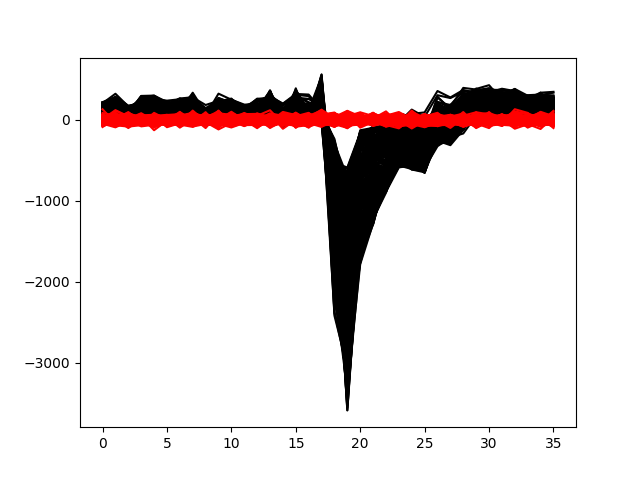

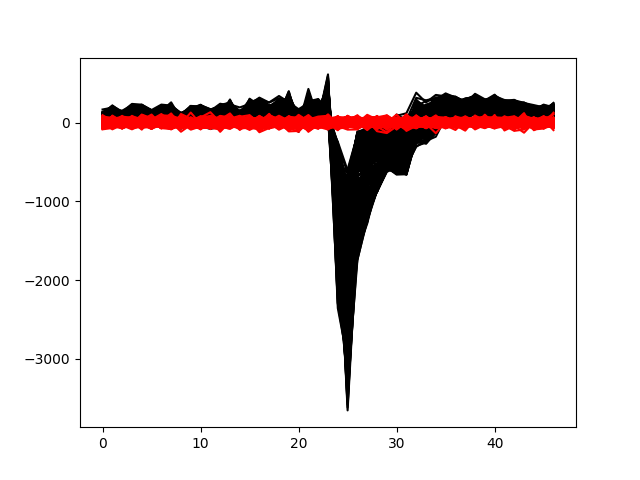

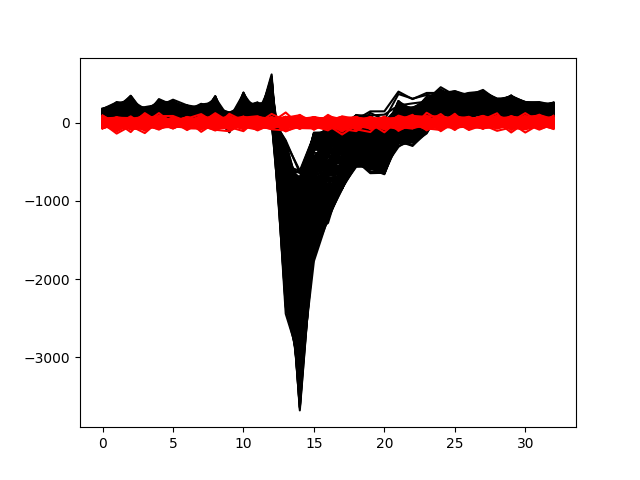

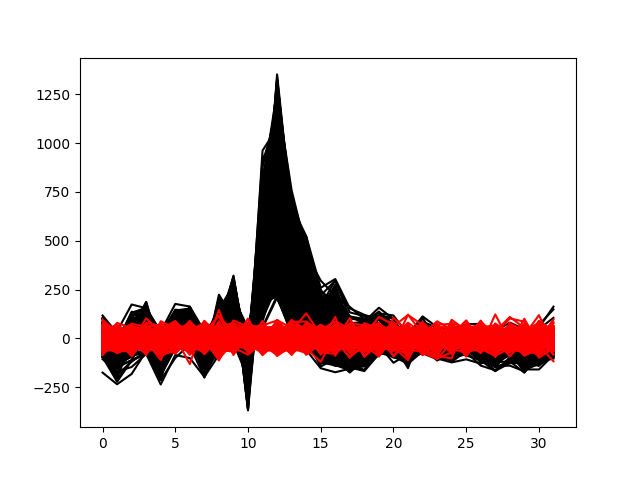

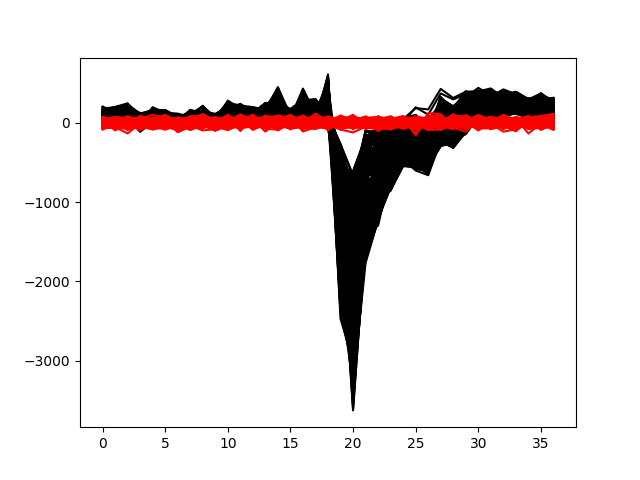

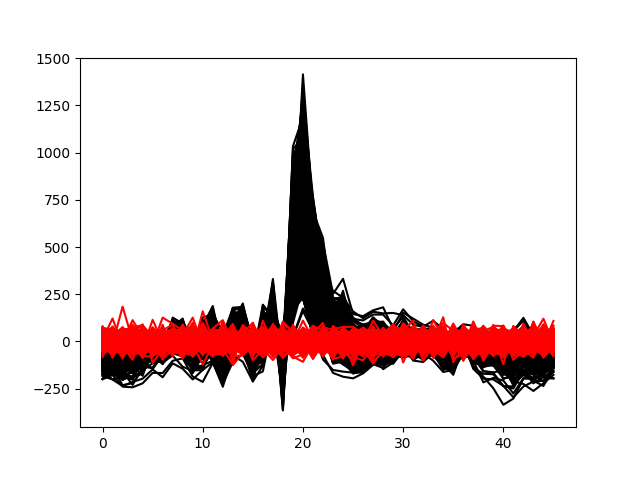

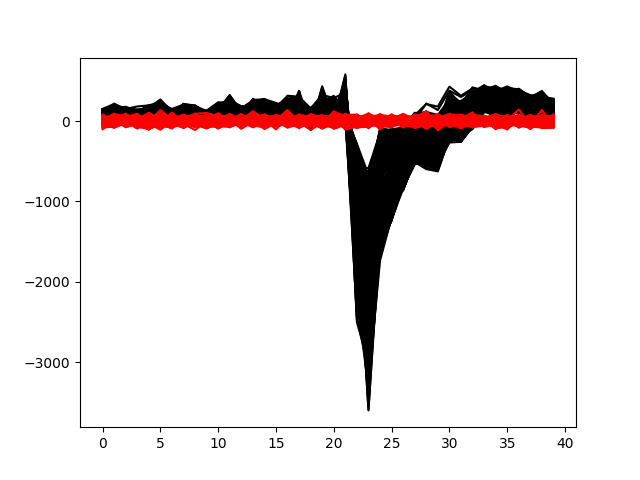

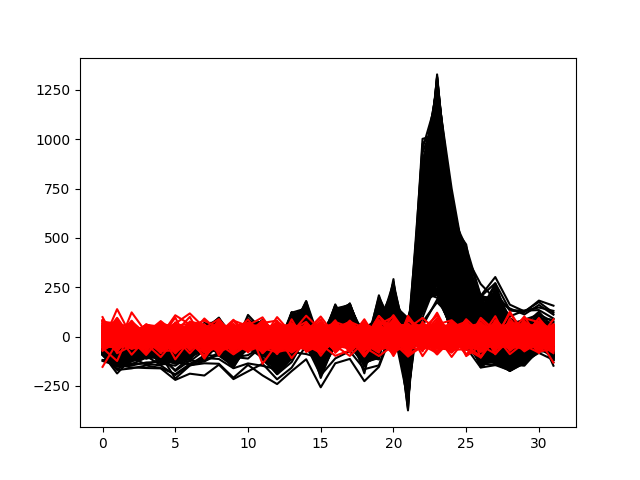

In [76]:
for interval in silence_intervals:
    print(interval)
    tr = rec.get_traces(start_frame=interval[0], end_frame=interval[1], return_scaled=True)
    tr_sil = rec_silence.get_traces(start_frame=interval[0], end_frame=interval[1], return_scaled=True)
    plt.figure()
    _ = plt.plot(tr, color="k")
    _ = plt.plot(tr_sil, color="r")

In [42]:
rec_silence = spre.silence_periods(rec, silence_intervals, mode="noise")

In [49]:
rec_silence

SilencedPeriodsRecording: 384 channels - 30.0kHz - 1 segments - 90,000 samples - 3.00s 
                          int16 dtype - 65.92 MiB

In [43]:
tr = rec.get_traces(start_frame=28000, end_frame=32000)
tr_sil = rec_silence.get_traces(start_frame=28000, end_frame=32000)

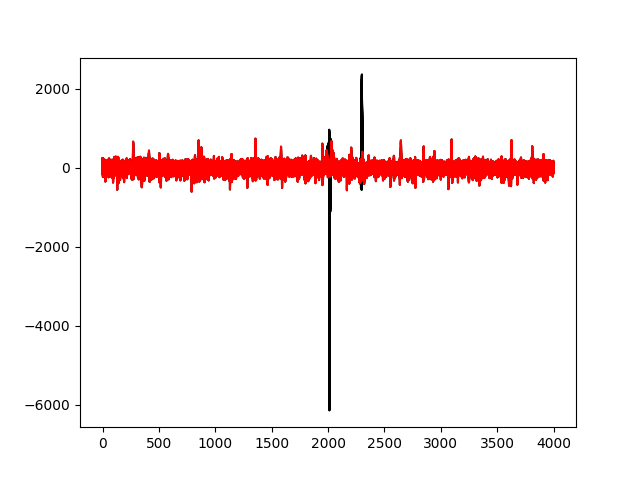

In [44]:
plt.figure()
_ = plt.plot(tr, color="k")
_ = plt.plot(tr_sil, color="r")

In [65]:
np.array(silence_intervals) / recording_hp.sampling_frequency

array([[0.01603333, 0.0165    ],
       [0.02496667, 0.02573333],
       [0.03826667, 0.03856667],
       [0.0565    , 0.057     ],
       [0.09976667, 0.10063333],
       [0.12316667, 0.1238    ],
       [0.13656667, 0.13716667],
       [0.1652    , 0.1657    ],
       [0.19313333, 0.19386667],
       [0.2244    , 0.22516667],
       [0.23386667, 0.23436667],
       [0.3106    , 0.31083333],
       [0.8137    , 0.81463333],
       [0.89486667, 0.89583333],
       [0.92816667, 0.9289    ]])

In [68]:
recording_layers = dict(
    orig=recording_hp,
    rm=rec_silence
)

w = sw.plot_traces(recording_layers, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [ ]:
def detect_bad_channels(recording, ):
    pass